# Algo Final Program

## Imports

In [1]:
import math
import random
import time
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import pandas as pd

## Fibonaci Heap Implementation

In [2]:
class FibonacciNode:
    def __init__(self, key):
        self.key = key
        self.left = self
        self.right = self
        self.parent = None
        self.child = None
        self.num_children = 0
        self.mark = False

        
class FibonacciHeap:
    def __init__(self):
        self.minimum = None
        self.num_nodes = 0

    '''
    returns the min value
    '''
    def get_min(self):
        return self.minimum

    '''
    removes and returns the min value
    '''
    def extract_min(self):
        minimum = self.minimum
        if minimum is not None:
            
            # If the minimum node has children, merge them into the root list
            if minimum.child is not None:
                # get all the children of the minimum node
                children = []
                for child in self._iterate(minimum.child):
                    children.append(child)
                
                # add children to the root list 
                for child in children:
                    self._add_to_list(child)
                    child.parent = None
                
            # Remove the minimum node from the doubly linked list
            minimum.left.right = minimum.right
            minimum.right.left = minimum.left
            
            # Update the minimum and consolidate the heap if needed
            if minimum is minimum.right:
                self.minimum = None
            else:
                self.minimum = minimum.right
                self._consolidate()
            self.num_nodes -= 1
        return minimum

    '''
    adds the param value to the root list
    returns the FibonacciNode created
    '''
    def insert(self, key):
        new_node = FibonacciNode(key)
        
        self._add_to_list(new_node)
        
        # Update the minimum if necessary
        if self.minimum is None or key < self.minimum.key:
            self.minimum = new_node
            
        self.num_nodes += 1
        return new_node

    '''
    given a FibonacciNode alter the key value
    new key must be less than node.key
    '''
    def decrease_key(self, node, new_key):
        if new_key > node.key:
            return None
        
        node.key = new_key
        
        # Check if the node.key is less than its parent.key
        parent = node.parent
        if parent is not None and new_key < parent.key:
            self._cut(node, parent)
            self._cascading_cut(parent)
            
        # Update the minimum if necessary
        if new_key < self.minimum.key:
            self.minimum = node

    '''
    given 2 FibonacciHeaps
    returns 1 combined heap
    '''
    def merge(self, heap_to_merge):
        new_heap = FibonacciHeap()
        
        # Merge root lists and update min node
        
        # set new_heap to self heap
        new_heap.minimum = self.minimum
        
        last = heap_to_merge.minimum.left
        
        heap_to_merge.minimum.left = new_heap.minimum.left
        
        new_heap.minimum.left.right = heap_to_merge.minimum
        
        new_heap.minimum.left = last
        
        new_heap.minimum.left.right = new_heap.minimum
        
        if heap_to_merge.minimum.key < new_heap.minimum.key:
            new_heap.minimum = heap_to_merge.minimum
            
        # Update total number of nodes
        new_heap.num_nodes = self.num_nodes + heap_to_merge.num_nodes
        return new_heap

    def _cascading_cut(self, node):
        parent = node.parent
        if parent is not None:
            # if node is not in root list
            if node.mark is False:
                node.mark = True
            else:
                # If the node is marked, cut it from its parent and continue cascading
                self._cut(node, parent)
                self._cascading_cut(parent)

    def _consolidate(self):
        # Initialize root_nodes to store nodes of each quantity of children        
        log_num_nodes = math.log(self.num_nodes)
        num_root_nodes = int(log_num_nodes * 2)

        # Initialize an array to hold the number of children
        root_nodes = [None] * num_root_nodes
        
        # Collect all nodes from the root list
        all_nodes = []
        for node in self._iterate(self.minimum):
            all_nodes.append(node)

        # Iterate over each node in the root list
        for current_node in all_nodes:
            current_num_children = current_node.num_children
            
            # Merge trees of equal degree
            while root_nodes[current_num_children] is not None:
                other_node = root_nodes[current_num_children]
                
                # Swap nodes to maintain min-heap property
                if current_node.key > other_node.key:
                    temp = current_node
                    current_node, other_node = other_node, temp
                    
                self._heap_link(other_node, current_node)
                
                # Empty the degree bucket and move to the next degree
                root_nodes[current_num_children] = None
                current_num_children += 1
                
            # add current node to the current degree bucket
            root_nodes[current_num_children] = current_node
            
        # Find the new minimum node in the root list
        for root_node in root_nodes:
            if root_node is not None:
                if root_node.key < self.minimum.key:
                    self.minimum = root_node
                    
    def _cut(self, child, parent):
        # remove from child list
        if parent.child is parent.child.right:
            # parent has one chile
            parent.child = None
        elif parent.child is child:
            # node is first chile of parent
            parent.child = child.right
            child.right.parent = parent
            
        # Remove the node from the child list
        child.left.right = child.right
        child.right.left = child.left
        
        parent.num_children -= 1
        self._add_to_list(child)
        child.parent = None
        child.mark = False
 
    def _iterate(self, begining):
        node = begining
        loop_completed = False
        while True:
            if node == begining:
                loop_completed = True
            yield node
            node = node.right
            if node == begining and loop_completed is True:
                break

    def _add_to_list(self, node):
        if self.minimum is None:
            # If root list is empty, set node as the root list
            self.minimum = node
        else:
            # Insert node into the root list
            node.right = self.minimum.right
            node.left = self.minimum
            self.minimum.right.left = node
            self.minimum.right = node
            
    def _heap_link(self, node1, node2):
        # Remove node1 from the root list
        if node1 is self.minimum:
            # node is head of root list
            self.minimum = node1.right
        
        # Remove the node from the doubly linked list
        node1.left.right = node1.right
        node1.right.left = node1.left
        
        # Reset node1's left and right references
        node1.left = node1
        node1.right = node1
        
        # Merge node1 into node2's child list        
        if node2.child is None:
            # If parent has no child, set node as the child
            node2.child = node1
        else:
            # Insert node into child list
            node1.right = node2.child.right
            node1.left = node2.child
            node2.child.right.left = node1
            node2.child.right = node1   
        
        node2.num_children += 1
        
        # Update node1's parent and mark
        node1.parent = node2
        node1.mark = False


## Fibonacci Heap Validation

In [3]:
heap = FibonacciHeap()
t2 = heap.get_min()
t3 = heap.extract_min()
message = "pass" if t2 == t3 == None else "fail"
print("empty heap test:        " + message)

heap = FibonacciHeap()
heap.insert(1)
t2 = heap.get_min().key
t3 = heap.extract_min().key
message = "pass" if t2 == t3 == 1 else "fail"
print("1 value heap test:      " + message)

heap = FibonacciHeap()
heap.insert(5)
heap.insert(1)
t2 = heap.get_min().key
t3 = heap.extract_min().key
message = "pass" if t2 == t3 == 1 else "fail"
print("2 diff value heap test: " + message)

heap = FibonacciHeap()
heap.insert(1)
heap.insert(1)
t2 = heap.get_min().key
t3 = heap.extract_min().key
message = "pass" if t2 == t3 == 1 else "fail"
print("2 same heap test:       " + message)

heap = FibonacciHeap()
for n in range(1,10):
    heap.insert(n)

passed = True
for n in range(1,10):
    m = heap.extract_min().key
    if n != m:
        passed = False
        print("extract_min test:       Fail")
        break

if passed:
    print("extract_min test:       pass")
    
heap = FibonacciHeap()
node = heap.insert(5)
heap.insert(1)
heap.decrease_key(node, 0)

message = "pass" if heap.get_min().key == 0 else "fail"
print("decrease key heap test: " + message)

empty heap test:        pass
1 value heap test:      pass
2 diff value heap test: pass
2 same heap test:       pass
extract_min test:       pass
decrease key heap test: pass


## Fibonacci Heap Benchmarking

Operation | Amortized Running Time
----------|-----------------------
insert | $O(1)$
get_min | $O(1)$
extract_min | $O(log n)$
decrease_key | $O(1)$
merge | $O(1)$



### Benchmarking insert

In [4]:
def insert_benchmark(heap_to_insert):
    start_time = time.perf_counter()
    heap_to_insert.insert(-1)
    return (time.perf_counter() - start_time)

In [5]:
insert_100 = FibonacciHeap()
for i in range(100):
    node_100 = insert_100.insert(i)

insert_1000 = FibonacciHeap()
for i in range(1000):
    node_1000 = insert_1000.insert(i)

insert_10000 = FibonacciHeap()
for i in range(10000):
    node_10000 = insert_10000.insert(i)

insert_25000 = FibonacciHeap()
for i in range(25000):
    node_25000 = insert_25000.insert(i)

insert_50000 = FibonacciHeap()
for i in range(50000):
    node_50000 = insert_50000.insert(i)

insert_75000 = FibonacciHeap()
for i in range(75000):
    node_75000 = insert_75000.insert(i)

insert_100000 = FibonacciHeap()
for i in range(100000):
    node_100000 = insert_100000.insert(i)

insert_benchmarks = list()
insert_benchmarks.append(insert_benchmark(insert_100) * 1E6)
insert_benchmarks.append(insert_benchmark(insert_1000) * 1E6)
insert_benchmarks.append(insert_benchmark(insert_10000) * 1E6)
insert_benchmarks.append(insert_benchmark(insert_25000) * 1E6)
insert_benchmarks.append(insert_benchmark(insert_50000) * 1E6)
insert_benchmarks.append(insert_benchmark(insert_75000) * 1E6)
insert_benchmarks.append(insert_benchmark(insert_100000) * 1E6)

### Benchmarking get_min

In [6]:
def get_min_benchmark(heap_to_insert):
    start_time = time.perf_counter()
    heap_to_insert.get_min().key
    return (time.perf_counter() - start_time)

In [7]:
get_min_benchmarks = list()
get_min_benchmarks.append(get_min_benchmark(insert_100) * 1E6)
get_min_benchmarks.append(get_min_benchmark(insert_1000) * 1E6)
get_min_benchmarks.append(get_min_benchmark(insert_10000) * 1E6)
get_min_benchmarks.append(get_min_benchmark(insert_25000) * 1E6)
get_min_benchmarks.append(get_min_benchmark(insert_50000) * 1E6)
get_min_benchmarks.append(get_min_benchmark(insert_75000) * 1E6)
get_min_benchmarks.append(get_min_benchmark(insert_100000) * 1E6)

### Benchmarking extract_min

In [8]:
def extract_min_benchmark(heap_to_insert):
    start_time = time.perf_counter()
    heap_to_insert.extract_min().key
    return (time.perf_counter() - start_time)

In [9]:
extract_min_benchmarks = list()
extract_min_benchmarks.append(extract_min_benchmark(insert_100))
extract_min_benchmarks.append(extract_min_benchmark(insert_1000))
extract_min_benchmarks.append(extract_min_benchmark(insert_10000))
extract_min_benchmarks.append(extract_min_benchmark(insert_25000))
extract_min_benchmarks.append(extract_min_benchmark(insert_50000))
extract_min_benchmarks.append(extract_min_benchmark(insert_75000))
extract_min_benchmarks.append(extract_min_benchmark(insert_100000))

### Benchmarking decrease_key

In [10]:
def decrease_key_benchmark(heap, node, value):
    start_time = time.perf_counter()
    heap.decrease_key(node, value)
    return (time.perf_counter() - start_time)

In [11]:
decrease_key_benchmarks = list()
decrease_key_benchmarks.append(decrease_key_benchmark(insert_100, node_100, -1) * 1E6)
decrease_key_benchmarks.append(decrease_key_benchmark(insert_1000, node_1000, -1) * 1E6)
decrease_key_benchmarks.append(decrease_key_benchmark(insert_10000, node_10000, -1) * 1E6)
decrease_key_benchmarks.append(decrease_key_benchmark(insert_25000, node_25000, -1) * 1E6)
decrease_key_benchmarks.append(decrease_key_benchmark(insert_50000, node_50000, -1) * 1E6)
decrease_key_benchmarks.append(decrease_key_benchmark(insert_75000, node_75000, -1) * 1E6)
decrease_key_benchmarks.append(decrease_key_benchmark(insert_100000, node_100000, -1) * 1E6)

### List sizes

In [12]:
list_sizes = [100, 1000, 10000, 25000, 50000, 75000, 100000]

### Insert benchmarking graph

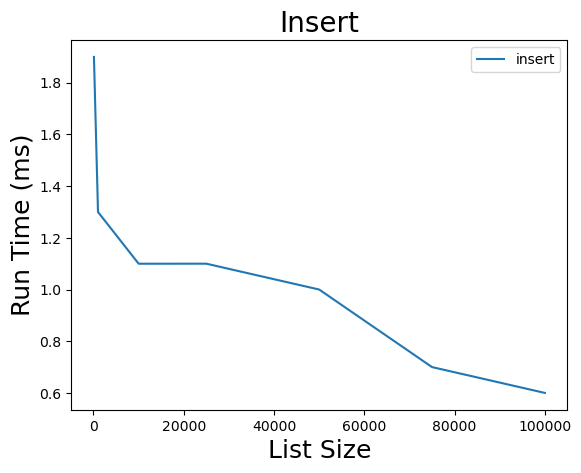

In [13]:
plt.plot(list_sizes, insert_benchmarks, label = "insert")
plt.xlabel("List Size", fontsize = 18)
plt.ylabel("Run Time (ms)", fontsize = 18)
plt.title("Insert", fontsize = 20)
plt.legend()

### get_min benchmarking graph

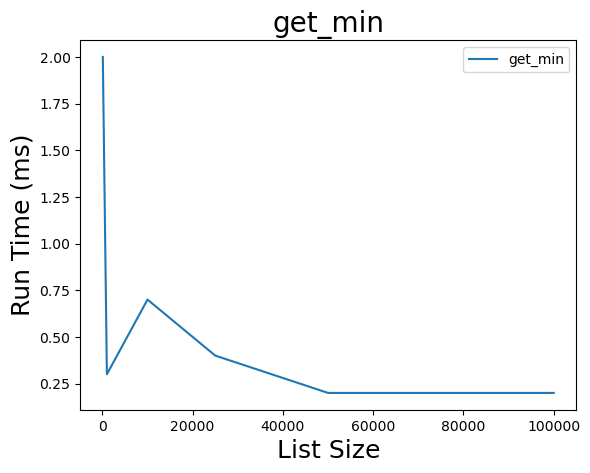

In [14]:
plt.plot(list_sizes, get_min_benchmarks, label = "get_min")
plt.xlabel("List Size", fontsize = 18)
plt.ylabel("Run Time (ms)", fontsize = 18)
plt.title("get_min", fontsize = 20)
plt.legend()

### extract_min benchmarking graph

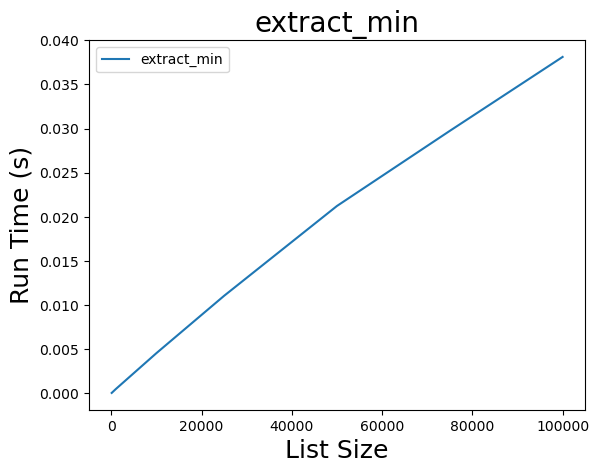

In [15]:
plt.plot(list_sizes, extract_min_benchmarks, label = "extract_min")
plt.xlabel("List Size", fontsize = 18)
plt.ylabel("Run Time (s)", fontsize = 18)
plt.title("extract_min", fontsize = 20)
plt.legend()

### decrease_key benchmarking graph

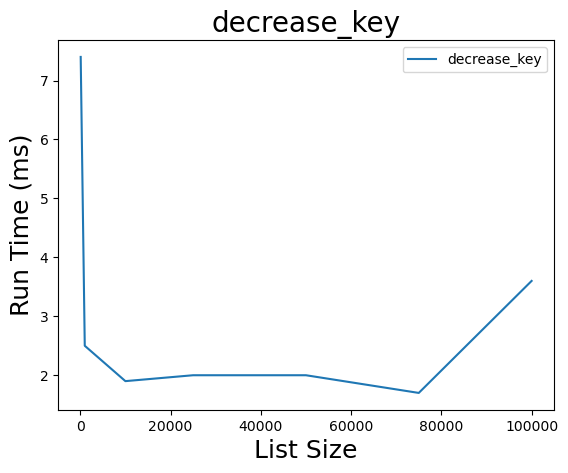

In [16]:
plt.plot(list_sizes, decrease_key_benchmarks, label = "decrease_key")
plt.xlabel("List Size", fontsize = 18)
plt.ylabel("Run Time (ms)", fontsize = 18)
plt.title("decrease_key", fontsize = 20)
plt.legend()